In [1]:
import spectral_graph as sg
import util
import time
import numpy as np
import matplotlib.pyplot as mpl
from scipy.signal import lfilter, firls, decimate

Running the Spectral Graph Model code: `NetworkTranferFunction` is the actual math portion.
Some details:
`get_Julia_order()` - Sort the region numbering so that the MEG region order and connectiviy region order are the same.

In [2]:
hcp_dir = util.get_absolute_path('./data/')

# Get structural connectivity matrix + distance between regions
Cdk_conn, Ddk_conn, perm_HCP = sg.get_HCP_connectome(hcp_dir)
perm_Julia, empty_Julia, cort_Julia = sg.get_Julia_order()

# Some other ordering that was in the original code:
linds = np.concatenate([np.arange(0,34), np.arange(68,77)])
rinds = np.concatenate([np.arange(34,68), np.arange(77,86)])

In [3]:
q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])

In [4]:
Cdk_conn = sg.bi_symmetric_c(Cdk_conn, linds, rinds)
C = sg.reduce_extreme_dir(Cdk_conn)

In [5]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

### Calculating frequency responses

In [11]:
# Compute for all frequencies in fvec - this is the debug part in Ashish's SCFC_onJuliaMEG3.m
#freqresp = []

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = sg.network_transfer_function(C, Ddk_conn, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)
# np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Computation time =  0.4741036891937256


### Plotting: first eigen values, eigen vectors, and their frequency responses

#### this code doesn't load optimized parameters, so we are only subplotting 2 figures- both with default parameters. The 3rd figure is split into a separate cell is commented out

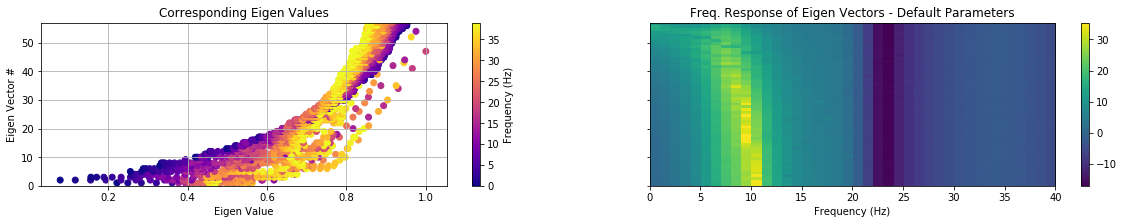

In [12]:
# Plotting eigen values of each eigen vector
#mpl.figure(num=5)
cmap = mpl.get_cmap('plasma')
fig_ev, ax_ev = mpl.subplots(1,2, figsize = (20,3), sharey = True)
for i in np.arange(0,evec.shape[1]):
    fig0=ax_ev[0].scatter(np.abs(evec[:,i]), np.ones(evec.shape[0])*(i+1), c = np.arange(0,fvec.size), cmap = cmap)
    
ax_ev[0].grid(True)
clb = fig_ev.colorbar(fig0, ax=ax_ev[0])
ax_ev[0].set_xlabel('Eigen Value')
ax_ev[0].set_ylabel('Eigen Vector #')
ax_ev[0].set_title('Corresponding Eigen Values')
clb.ax.set_ylabel('Frequency (Hz)')
#mpl.savefig('ev_Vv_plot.png', dpi = 300, format = 'png')

# Plotting eigen vector's frequency response with default parameters
ev_freqresp = np.abs(np.transpose(fqall))
#fig_ev, ax_ev = mpl.subplots()
ax1=ax_ev[1].imshow(sg.mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
#fig_ev.colorbar(ax1)
ax_ev[1].set_title('Freq. Response of Eigen Vectors - Default Parameters')
ax_ev[1].set_xlabel('Frequency (Hz)')
fig_ev.colorbar(ax1)
#mpl.savefig('freqresp_eigs_default.png', dpi = 300, format = 'png')

The following are all commented out - read the first 3 lines of comments!! 

In [13]:
"""
# eig vs. freq figure with set of optimized parameters - not loading any with this current version! 
# merge with above cell and change subplot to 3 plots if you end up loading optimized parameters!
# delete the colorbar for the 2nd plot and use this plot's colorbar instead.
evec = []
Vvec =[]
fqall = []
freq_model = []

# opparam = loadmat('/home/axiezai/lab/SCFC_eeg/data/SCFC_opparam_HCP.mat')
# optau_e = opparam['output']['param'][0,1][0]
# optau_i = opparam['output']['param'][0,1][1]
# opalpha = opparam['output']['param'][0,1][2]
# opspeed = opparam['output']['param'][0,1][3]
# opgei = opparam['output']['param'][0,1][4]
# opgii = opparam['output']['param'][0,1][5]
# optauC = opparam['output']['param'][0,1][6]

freq_model = np.transpose(freq_model)
np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

# Plotting eigen vector's frequency response
ev_freqresp = np.abs(np.transpose(fqall))
ax1 = ax_ev[2].imshow(sg.mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
fig_ev.colorbar(ax1)
ax_ev[2].set_title('Freq. Response of Eigen Vectors - Optimized Parameters')
ax_ev[2].set_xlabel('Frequency (Hz)')
mpl.savefig('freqresp_eigs.png', dpi = 300, format = 'png')
"""

"\n# eig vs. freq figure with set of optimized parameters\n# merge with above cell and change subplot to 3 plots\n# delete the colorbar for the 2nd plot and use this plot's colorbar instead.\nevec = []\nVvec =[]\nfqall = []\nfreq_model = []\n\n# opparam = loadmat('/home/axiezai/lab/SCFC_eeg/data/SCFC_opparam_HCP.mat')\n# optau_e = opparam['output']['param'][0,1][0]\n# optau_i = opparam['output']['param'][0,1][1]\n# opalpha = opparam['output']['param'][0,1][2]\n# opspeed = opparam['output']['param'][0,1][3]\n# opgei = opparam['output']['param'][0,1][4]\n# opgii = opparam['output']['param'][0,1][5]\n# optauC = opparam['output']['param'][0,1][6]\n\nfor i in fvec:\n    w = 2*np.pi*i\n    fq, ev, Vv, freqresp_out, _ = sg.network_transfer_function(C, Ddk_conn, w) #,tau_e = optau_e, tau_i = optau_i, alpha = opalpha, \n                                                          #speed = opspeed, gei = opgei, gii = opgii, tauC = optauC)\n    fqall.append(fq)\n    evec.append(ev)\n    Vvec.append(

## Plotting Magnitudes

Text(0,0.5,'Magnitude (dB)')

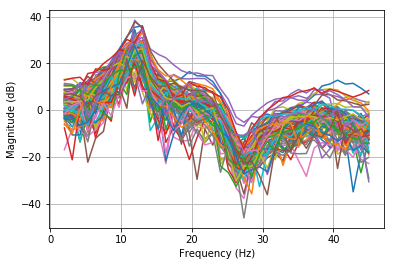

In [14]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,sg.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))